# Analysis of HDF5 Darshan Logs with PyDarshan

_Last updated: February 2021_

## Darshan

[Darshan](https://www.mcs.anl.gov/research/projects/darshan/) is a diagnostic tool for HPC I/O profiling. It's design makes it applicable for continuous monitoring and not just sporadic I/O performance investigations. Darshan consists of two independent components for generating and analyzing profiling information. The source code and its release archives are available from https://xgitlab.cels.anl.gov/darshan/darshan.

### Darshan Profiling Information

The profiling information includes basic runtime information, mounted file systems, _records_, and _modules_. Records are numeric identifiers representing the storage objects for which profiling information is available. Modules represent different types of I/O operations, such as POSIX, MPI-IO, STDIO, etc. Each module has a number of _counters_ that represent various statistical properties of the module's I/O operations.

Complete Darshan documentation is available at https://www.mcs.anl.gov/research/projects/darshan/documentation/.

### PyDarshan

PyDarshan is a Python package for Darshan profiling data analysis and visualization.

#### Installation

There are two ways how to install PyDarshan. Those interested in Darshan data analysis only should use the standard Python method with the `pip` command. For PyDarshan development, install from the source code in the Darshan repository mentioned above.

First, obtain Darshan source code and install a collection of tools for parsing and summarizing Darshan output files:
```shell
$ cd darshan-util
$ ./configure --prefix=INSTALLDIR --enable-shared
$ make install
```
If successful, add to the `$PATH` environment variable the folder where the `darshan-parser` tool is located. Then:
```shell
$ pip install darshan
```
installs PyDarshan.

If interested in PyDarshan development, the final step above is slightly different:
```shell
$ cd darshan-util/pydarshan
$ pip install -e .
```

#### Documentation

PyDarshan documentation is for now only available from the [repository](https://xgitlab.cels.anl.gov/darshan/darshan/-/tree/master/darshan-util/pydarshan/docs) in its "source" reStructuredText format. Use the standard Python method to convert it into any of the typical viewable formats.

## HDF5

[HDF5](https://www.hdfgroup.org/solutions/hdf5/) is a data model, library, and file format for storing and managing data. It supports an unlimited variety of datatypes, and is designed for flexible and efficient I/O and for high volume and complex data. The HDF5 Technology suite includes tools and applications for managing, manipulating, viewing, and analyzing data in the HDF5 format.

Darshan provides HDF5-specific profiling data in two modules: [H5F](https://www.mcs.anl.gov/research/projects/darshan/docs/darshan-util.html#idm773) and [H5D](https://www.mcs.anl.gov/research/projects/darshan/docs/darshan-util.html#idm813) when the Darshan profiling tool is built with the ``--enable-hdf5-mod=/path/to/hdf5/install`` configure option.



## Tutorial

PyDarshan at this time is in early stage of the development so its API may change. We are going to indicate when using any feature marked experimental as of now.

### Runtime Environment

Python version:

In [1]:
from platform import python_version
python_version()

'3.8.7'

Packages and their versions:

In [2]:
from pprint import pprint
import pandas as pd
import numpy as np
import darshan

In [3]:
for _ in (pd, darshan, np):
    print(f'{_.__name__} v{_.__version__}')

pandas v1.2.1
darshan v0.0.7
numpy v1.20.0


### Reading Darshan Profiling Information

We are using Darshan profiling data that includes the two HDF5-specific modules. By default, PyDarshan will convert module counter data to pandas.DataFrame objects. The other option are NumPy arrays (`dtype='numpy'`) and we opted for that because we create our own pandas.DataFrame objects for HDF5 module counters later in this notebook.

In [4]:
rep = darshan.DarshanReport('./example.darshan', dtype='numpy')

 Skipping. Log does not contain data for mod: LUSTRE


The Python object representing the Darshan report:

In [5]:
rep

### Displaying Basic Information

Below is the information derived from the default header section:

In [6]:
rep.info(metadata=False)

Filename:       ./example.darshan
Times:          2020-09-03 16:02:26 to 2020-09-03 16:02:38 (Duration 0:00:12)
Executeable:    ./hdf5_iotest run-1.ini
Processes:      4
JobID:          22156
UID:            1000
Modules in Log: ['POSIX', 'MPI-IO', 'H5F', 'H5D', 'STDIO']
Loaded Records: {'POSIX': 1, 'MPI-IO': 1, 'H5F': 1, 'H5D': 1359, 'STDIO': 3}
Name Records:   803
Darshan/Hints:  {'lib_ver': '3.2.1', 'h': 'romio_no_indep_rw=true;cb_nodes=4'}
DarshanReport:  id(4789627680) (tmp)


Note the lines in the above report: _Modules in Log_ and _Loaded Records_. The first line shows all modules present in the Darshan file, while the second line shows only the modules which data were read in.

Setting `metadata=True` adds more metadata information to display:

In [7]:
rep.info(metadata=True)

Filename:       ./example.darshan
Times:          2020-09-03 16:02:26 to 2020-09-03 16:02:38 (Duration 0:00:12)
Executeable:    ./hdf5_iotest run-1.ini
Processes:      4
JobID:          22156
UID:            1000
Modules in Log: ['POSIX', 'MPI-IO', 'H5F', 'H5D', 'STDIO']
Loaded Records: {'POSIX': 1, 'MPI-IO': 1, 'H5F': 1, 'H5D': 1359, 'STDIO': 3}
Name Records:   803
Darshan/Hints:  {'lib_ver': '3.2.1', 'h': 'romio_no_indep_rw=true;cb_nodes=4'}
DarshanReport:  id(4789627680) (tmp)
metadata['job']['uid'] = 1000
metadata['job']['start_time'] = 1599163346
metadata['job']['end_time'] = 1599163358
metadata['job']['nprocs'] = 4
metadata['job']['jobid'] = 22156
metadata['job']['metadata'] = {'lib_ver': '3.2.1', 'h': 'romio_no_indep_rw=true;cb_nodes=4'}
metadata['exe'] = ./hdf5_iotest run-1.ini


The "metadata" part is also available separately as a dictionary:

In [8]:
pprint(rep.metadata)

{'exe': './hdf5_iotest run-1.ini',
 'job': {'end_time': 1599163358,
         'jobid': 22156,
         'metadata': {'h': 'romio_no_indep_rw=true;cb_nodes=4',
                      'lib_ver': '3.2.1'},
         'nprocs': 4,
         'start_time': 1599163346,
         'uid': 1000}}


Darshan report's file name:

In [9]:
rep.filename

'./example.darshan'

Start and end time of the profiling job are available as `datetime.datetime` objects but without a time zone specified:

In [10]:
rep.start_time

datetime.datetime(2020, 9, 3, 16, 2, 26)

In [11]:
rep.end_time

datetime.datetime(2020, 9, 3, 16, 2, 38)

In [12]:
rep.start_time.tzinfo is None

True

### Darshan Modules, Records, Counters

Available modules and their basic information are available as a dictionary of dictionaries:

In [13]:
rep.modules

{'POSIX': {'len': 270, 'ver': 4, 'idx': 1, 'num_records': 1},
 'MPI-IO': {'len': 212, 'ver': 3, 'idx': 2, 'num_records': 1},
 'H5F': {'len': 50, 'ver': 3, 'idx': 3, 'num_records': 1},
 'H5D': {'len': 91756, 'ver': 1, 'idx': 4, 'num_records': 1359},
 'STDIO': {'len': 174, 'ver': 2, 'idx': 8, 'num_records': 3}}

The mounted file systems and their types are available as a list of two-item tuples `(<mount point>, <fs type>)`:

In [14]:
rep.mounts

[('/proc/sys/fs/binfmt_misc', 'autofs'),
 ('/sys/fs/cgroup/unified', 'cgroup2'),
 ('/sys/fs/pstore', 'pstore'),
 ('/mnt/scratch', 'ext4'),
 ('/sys/fs/bpf', 'bpf'),
 ('/dev/mqueue', 'mqueue'),
 ('/boot/efi', 'vfat'),
 ('/dev', 'devtmpfs'),
 ('/', 'ext4')]

Record IDs and their full file system paths are available as a dictionary:

In [15]:
len(rep.name_records)

803

In [16]:
rep.name_records

59226111675751: '/mnt/scratch/out-1.h5:/step=0/array=490',
 5075477941040549916: '/mnt/scratch/out-1.h5:/step=0/array=491',
 2656080831511421580: '/mnt/scratch/out-1.h5:/step=0/array=492',
 981813292813725046: '/mnt/scratch/out-1.h5:/step=0/array=493',
 7088267117835563390: '/mnt/scratch/out-1.h5:/step=0/array=494',
 9797097948874073156: '/mnt/scratch/out-1.h5:/step=0/array=495',
 2470883244632348843: '/mnt/scratch/out-1.h5:/step=0/array=496',
 5946348691341731964: '/mnt/scratch/out-1.h5:/step=0/array=497',
 14802219618710625791: '/mnt/scratch/out-1.h5:/step=0/array=498',
 17606145139435315027: '/mnt/scratch/out-1.h5:/step=0/array=499',
 561704199900244003: '/mnt/scratch/out-1.h5:/step=1/array=0',
 12109967703595006251: '/mnt/scratch/out-1.h5:/step=1/array=1',
 17085615950698936687: '/mnt/scratch/out-1.h5:/step=1/array=2',
 11597017616278610449: '/mnt/scratch/out-1.h5:/step=1/array=3',
 462746467154257129: '/mnt/scratch/out-1.h5:/step=1/array=4',
 11381211498974871650: '/mnt/scratch/ou

HDF5 records also include dataset path names:

In [17]:
rep.name_records[4213945677347829095]

'/mnt/scratch/out-1.h5:/step=1/array=296'

The above record name has two parts:

1. the complete HDF5 file name, `/mnt/scratch/out-1.h5`, and
1. HDF5 dataset path name,  `/step=1/array=296`.

All the counters present in the Darshan file are available as a dictionary from the `.counters` property. They are organized per their modules:

In [18]:
rep.counters.keys()

dict_keys(['POSIX', 'MPI-IO', 'H5F', 'H5D', 'STDIO'])

The counters for each module are further separated into _integer_ and _floating-point_ groups:

In [19]:
rep.counters['H5F'].keys()

dict_keys(['counters', 'fcounters'])

For example, integer counters for the H5F module are:

In [20]:
rep.counters['H5F']['counters']

['H5F_OPENS', 'H5F_FLUSHES', 'H5F_USE_MPIIO']

and H5F's floating-point counters are:

In [21]:
rep.counters['H5F']['fcounters']

['H5F_F_OPEN_START_TIMESTAMP',
 'H5F_F_CLOSE_START_TIMESTAMP',
 'H5F_F_OPEN_END_TIMESTAMP',
 'H5F_F_CLOSE_END_TIMESTAMP',
 'H5F_F_META_TIME']

H5D module counters are:

In [22]:
pprint(rep.counters['H5D'])

{'counters': ['H5D_OPENS',
              'H5D_READS',
              'H5D_WRITES',
              'H5D_FLUSHES',
              'H5D_BYTES_READ',
              'H5D_BYTES_WRITTEN',
              'H5D_RW_SWITCHES',
              'H5D_REGULAR_HYPERSLAB_SELECTS',
              'H5D_IRREGULAR_HYPERSLAB_SELECTS',
              'H5D_POINT_SELECTS',
              'H5D_MAX_READ_TIME_SIZE',
              'H5D_MAX_WRITE_TIME_SIZE',
              'H5D_SIZE_READ_AGG_0_100',
              'H5D_SIZE_READ_AGG_100_1K',
              'H5D_SIZE_READ_AGG_1K_10K',
              'H5D_SIZE_READ_AGG_10K_100K',
              'H5D_SIZE_READ_AGG_100K_1M',
              'H5D_SIZE_READ_AGG_1M_4M',
              'H5D_SIZE_READ_AGG_4M_10M',
              'H5D_SIZE_READ_AGG_10M_100M',
              'H5D_SIZE_READ_AGG_100M_1G',
              'H5D_SIZE_READ_AGG_1G_PLUS',
              'H5D_SIZE_WRITE_AGG_0_100',
              'H5D_SIZE_WRITE_AGG_100_1K',
              'H5D_SIZE_WRITE_AGG_1K_10K',
              'H5D_SIZE_

### Plotting Profiling Data

Plotting in PyDarshan is currently marked as an experimental feature and must be first enabled and then the plotting functions can be imported from their experimental module:

In [23]:
darshan.enable_experimental()
from darshan.experimental.plots.matplotlib import plot_access_histogram, plot_opcounts

Below are the kinds of plots that do work for our Darshan file with HDF5-specific profiling information. It is important to note that the plots presented here may or may not work for every Darshan report as they are dependent on what profiling data are available in the actual file.

Summarizing... iohist POSIX


<module 'matplotlib.pyplot' from '/Users/ajelenak/.pyenv/darshan/lib/python3.8/site-packages/matplotlib/pyplot.py'>

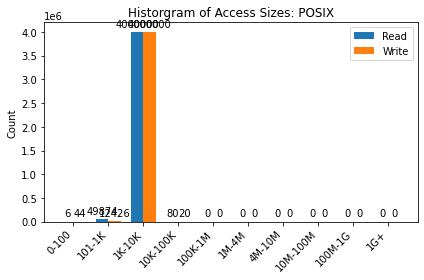

In [24]:
plot_access_histogram(rep, 'POSIX')

Summarizing... iohist MPI-IO


<module 'matplotlib.pyplot' from '/Users/ajelenak/.pyenv/darshan/lib/python3.8/site-packages/matplotlib/pyplot.py'>

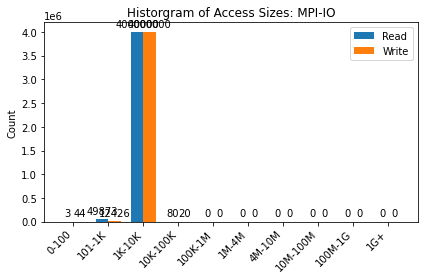

In [25]:
plot_access_histogram(rep, 'MPI-IO')

Summarizing... agg_ioops
Read,Write,Open,Stat,Seek,Mmap,Fsync,Layer
4049960,4012490,10,2,6,0,0,POSIX
4049956,4012490,0,0,0,0,0,MPIIND
0,0,8,0,0,0,0,MPICOL
31,14,3,0,0,0,0,STDIO



<module 'matplotlib.pyplot' from '/Users/ajelenak/.pyenv/darshan/lib/python3.8/site-packages/matplotlib/pyplot.py'>

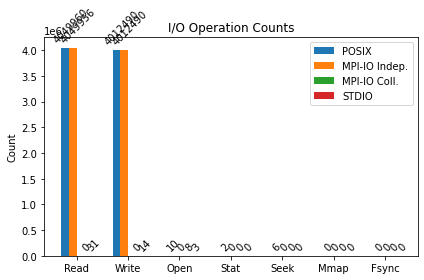

In [26]:
plot_opcounts(rep)

### Working with HDF5-Specific Profiling Data

PyDarshan currently does not support HDF5-specific modules so below is a function to reformat Darshan non-DXT module data to a pandas.DataFrame.

In [27]:
def module2df(rep: darshan.DarshanReport, module: str) -> pd.DataFrame:
    """Convert Darshan module log to pandas DataFrame.
    """
    mod_df = pd.DataFrame()
    for e in rep.records[module]:
        df1 = pd.DataFrame({'counter': rep.counters[module]['counters'],
                            'value': e['counters']})
        df2 = pd.DataFrame({'counter': rep.counters[module]['fcounters'], 
                            'value': e['fcounters']})
        df1 = pd.concat([df1, df2], axis=0, ignore_index=True)
        df1 = df1.assign(rank=e['rank'], record=rep.name_records[e['id']])
        mod_df = pd.concat([mod_df, df1], axis=0, ignore_index=True)

    return mod_df

Converting the H5F module data to a pandas.Dataframe gives:

In [28]:
h5f = module2df(rep, 'H5F')
h5f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   counter  8 non-null      object 
 1   value    8 non-null      float64
 2   rank     8 non-null      int64  
 3   record   8 non-null      object 
dtypes: float64(1), int64(1), object(2)
memory usage: 384.0+ bytes


In [29]:
h5f

counter      value  rank                 record
0                    H5F_OPENS   9.000000    -1  /mnt/scratch/out-1.h5
1                  H5F_FLUSHES   0.000000    -1  /mnt/scratch/out-1.h5
2                H5F_USE_MPIIO   1.000000    -1  /mnt/scratch/out-1.h5
3   H5F_F_OPEN_START_TIMESTAMP   0.001401    -1  /mnt/scratch/out-1.h5
4  H5F_F_CLOSE_START_TIMESTAMP   9.218065    -1  /mnt/scratch/out-1.h5
5     H5F_F_OPEN_END_TIMESTAMP  11.637774    -1  /mnt/scratch/out-1.h5
6    H5F_F_CLOSE_END_TIMESTAMP  11.637802    -1  /mnt/scratch/out-1.h5
7              H5F_F_META_TIME   0.315327    -1  /mnt/scratch/out-1.h5

There is not much data above since only one HDF5 file was involved. Still, it is possible to illustrate how to extract useful information in case (many) more HDF5 files were present.

For example, list of all HDF5 files:

In [30]:
h5f['record'].unique()

array(['/mnt/scratch/out-1.h5'], dtype=object)

Grouping H5F module data by the counter enables per-file analysis of all their data:

In [31]:
h5f_grp = h5f.groupby('counter')

The largest number of HDF5 file open operations:

In [32]:
h5f_grp.get_group('H5F_OPENS').max()

counter                H5F_OPENS
value                        9.0
rank                          -1
record     /mnt/scratch/out-1.h5
dtype: object

Top 5 HDF5 files with the longest cumulative times spent in open, close, or flush operations:

In [33]:
h5f_grp.get_group('H5F_F_META_TIME').nlargest(5, 'value', keep='all')

counter     value  rank                 record
7  H5F_F_META_TIME  0.315327    -1  /mnt/scratch/out-1.h5

Reformatting the H5D module data to a pandas.DataFrame yields:

In [34]:
h5d = module2df(rep, 'H5D')
h5d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150849 entries, 0 to 150848
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   counter  150849 non-null  object 
 1   value    150849 non-null  float64
 2   rank     150849 non-null  int64  
 3   record   150849 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


This DataFrame has many more rows so let's show just the first 10:

In [35]:
h5d.head(10)

counter     value  rank  \
0                        H5D_OPENS       8.0    -1   
1                        H5D_READS       4.0    -1   
2                       H5D_WRITES       4.0    -1   
3                      H5D_FLUSHES       0.0    -1   
4                   H5D_BYTES_READ  640000.0    -1   
5                H5D_BYTES_WRITTEN  640000.0    -1   
6                  H5D_RW_SWITCHES       4.0    -1   
7    H5D_REGULAR_HYPERSLAB_SELECTS       8.0    -1   
8  H5D_IRREGULAR_HYPERSLAB_SELECTS       0.0    -1   
9                H5D_POINT_SELECTS       0.0    -1   

                                    record  
0  /mnt/scratch/out-1.h5:/step=0/array=409  
1  /mnt/scratch/out-1.h5:/step=0/array=409  
2  /mnt/scratch/out-1.h5:/step=0/array=409  
3  /mnt/scratch/out-1.h5:/step=0/array=409  
4  /mnt/scratch/out-1.h5:/step=0/array=409  
5  /mnt/scratch/out-1.h5:/step=0/array=409  
6  /mnt/scratch/out-1.h5:/step=0/array=409  
7  /mnt/scratch/out-1.h5:/step=0/array=409  
8  /mnt/scratch/out-1.h5:/step=0/array=409  
9  /mnt/scratch/out-1.h5:/step=0/array=409

The number of records in this module are:

In [36]:
h5d['record'].unique().size

797

H5D module records are HDF5 datasets. Let's show the last 5:

In [37]:
h5d['record'].unique()[-5:]

array(['/mnt/scratch/out-1.h5:/step=1/array=68',
       '/mnt/scratch/out-1.h5:/step=1/array=62',
       '/mnt/scratch/out-1.h5:/step=1/array=24',
       '/mnt/scratch/out-1.h5:/step=1/array=261',
       '/mnt/scratch/out-1.h5:/step=1/array=20'], dtype=object)

Grouping on counters:

In [38]:
h5d_grp = h5d.groupby('counter')

we can start looking at I/O statistics across all HDF5 datasets or broken down per each dataset. For example, descriptive stats for slowest H5D read operations:

In [39]:
h5d_grp.get_group('H5D_MAX_READ_TIME_SIZE')['value'].describe()

count      1359.0
mean     160000.0
std           0.0
min      160000.0
25%      160000.0
50%      160000.0
75%      160000.0
max      160000.0
Name: value, dtype: float64

Descriptive stats about the total number of bytes written to each HDF5 dataset:

In [40]:
h5d_grp.get_group('H5D_BYTES_WRITTEN')['value'].describe()

count      1359.000000
mean     342251.655629
std      233034.521727
min      160000.000000
25%      160000.000000
50%      160000.000000
75%      640000.000000
max      640000.000000
Name: value, dtype: float64

The 10 smallest cumulative dataset read times:

In [41]:
h5d_grp.get_group('H5D_F_READ_TIME').nsmallest(10, 'value')

counter     value  rank  \
150285  H5D_F_READ_TIME  0.000179     3   
120648  H5D_F_READ_TIME  0.000179     3   
141072  H5D_F_READ_TIME  0.000179     3   
130083  H5D_F_READ_TIME  0.000179     3   
147843  H5D_F_READ_TIME  0.000179     3   
143514  H5D_F_READ_TIME  0.000179     3   
120870  H5D_F_READ_TIME  0.000180     3   
134079  H5D_F_READ_TIME  0.000180     3   
127752  H5D_F_READ_TIME  0.000180     3   
132303  H5D_F_READ_TIME  0.000180     3   

                                         record  
150285  /mnt/scratch/out-1.h5:/step=1/array=272  
120648  /mnt/scratch/out-1.h5:/step=1/array=108  
141072  /mnt/scratch/out-1.h5:/step=1/array=252  
130083  /mnt/scratch/out-1.h5:/step=1/array=213  
147843  /mnt/scratch/out-1.h5:/step=1/array=244  
143514  /mnt/scratch/out-1.h5:/step=1/array=282  
120870   /mnt/scratch/out-1.h5:/step=1/array=33  
134079  /mnt/scratch/out-1.h5:/step=1/array=151  
127752  /mnt/scratch/out-1.h5:/step=1/array=287  
132303   /mnt/scratch/out-1.h5:/step=1/array=31

Total number of bytes read from and written to each record (HDF5 dataset):

In [42]:
h5d_grp.get_group('H5D_BYTES_READ').groupby('record')['value'].sum()

record
/mnt/scratch/out-1.h5:/step=0/array=0      640000.0
/mnt/scratch/out-1.h5:/step=0/array=1      640000.0
/mnt/scratch/out-1.h5:/step=0/array=10     640000.0
/mnt/scratch/out-1.h5:/step=0/array=100    640000.0
/mnt/scratch/out-1.h5:/step=0/array=101    640000.0
                                             ...   
/mnt/scratch/out-1.h5:/step=1/array=95     480000.0
/mnt/scratch/out-1.h5:/step=1/array=96     480000.0
/mnt/scratch/out-1.h5:/step=1/array=97     480000.0
/mnt/scratch/out-1.h5:/step=1/array=98     480000.0
/mnt/scratch/out-1.h5:/step=1/array=99     480000.0
Name: value, Length: 797, dtype: float64

In [43]:
h5d_grp.get_group('H5D_BYTES_WRITTEN').groupby('record')['value'].sum()

record
/mnt/scratch/out-1.h5:/step=0/array=0      640000.0
/mnt/scratch/out-1.h5:/step=0/array=1      640000.0
/mnt/scratch/out-1.h5:/step=0/array=10     640000.0
/mnt/scratch/out-1.h5:/step=0/array=100    640000.0
/mnt/scratch/out-1.h5:/step=0/array=101    640000.0
                                             ...   
/mnt/scratch/out-1.h5:/step=1/array=95     480000.0
/mnt/scratch/out-1.h5:/step=1/array=96     480000.0
/mnt/scratch/out-1.h5:/step=1/array=97     480000.0
/mnt/scratch/out-1.h5:/step=1/array=98     480000.0
/mnt/scratch/out-1.h5:/step=1/array=99     480000.0
Name: value, Length: 797, dtype: float64

### Plotting HDF5 Profiling Data

PyDarshan currently does not support plotting HDF5 module data. Below are two example functions which are modeled on the current PyDarshan's plotting capabilities. They showcase how H5D module data as a pandas DataFrame can be as easily utilized for plotting as for analysis.

Another difference from PyDarshan plotting is the use of the [hvPlot](https://hvplot.holoviz.org/index.html), a high-level plotting API for the PyData ecosystem. It is an alternative to the plotting API provided by pandas which generates interactive plots that allow panning, zooming, hover data display, etc.

In [44]:
import hvplot
hvplot.__version__

'0.7.0'

In [45]:
def plot_h5d_access_histogram(grpby: pd.core.groupby.DataFrameGroupBy):
    """
    """
    ranges = ['0_100', '100_1K', '1K_10K', '10K_100K', '100K_1M', '1M_4M', 
              '4M_10M', '10M_100M', '100M_1G', '1G_PLUS']
    labels = ['0-100', '100-1K', '1K-10K', '10K-100K', '100K-1M', '1M-4M', 
              '4M-10M', '10M-100M', '100M-1G', '1G+']
    read_vals = [h5d_grp.get_group('H5D_SIZE_READ_AGG_' + rng)['value'].sum() 
                 for rng in ranges]
    write_vals = [h5d_grp.get_group('H5D_SIZE_WRITE_AGG_' + rng)['value'].sum() 
                 for rng in ranges]
    df = pd.DataFrame(data={'read': read_vals, 'write': write_vals},
                      index=labels)
    pd.options.plotting.backend = 'holoviews'
    return df.plot.bar(title='Histogram of Access Sizes: H5D', rot=45, ylabel='count')

In [46]:
def plot_h5d_opcounts(grpby: pd.core.groupby.DataFrameGroupBy):
    """
    """
    opens = h5d_grp.get_group('H5D_OPENS')['value'].sum()
    reads = h5d_grp.get_group('H5D_READS')['value'].sum()
    writes = h5d_grp.get_group('H5D_WRITES')['value'].sum()
    flushes = h5d_grp.get_group('H5D_FLUSHES')['value'].sum()
    df = pd.DataFrame(data={'open': opens, 'read': reads, 'write': writes,
                            'flush': flushes},
                            index=[0])
    pd.options.plotting.backend = 'holoviews'
    return df.plot.bar(title='H5D I/O Operations', ylabel='count')

In [47]:
plot_h5d_access_histogram(h5d_grp)

:Bars   [index,Variable]   (value)

In [48]:
plot_h5d_opcounts(h5d_grp)

:Bars   [index,Variable]   (value)

### The End